In [28]:
import numpy as np
import pandas as pd

def get_transition_matrix(val_col):
    transition_matrix = np.zeros((2, 2))

    for i in range(1, len(val_col)):
        today = val_col[i - 1]
        tomorrow = val_col[i]

        if today == 0:
            if tomorrow == 0:
                transition_matrix[0, 0] += 1
            else:
                transition_matrix[0, 1] += 1
        else:
            if tomorrow == 0:
                transition_matrix[1, 0] += 1
            else:
                transition_matrix[1, 1] += 1

    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(
        transition_matrix,
        row_sums,
        out=np.zeros_like(transition_matrix),
        where=row_sums != 0
    )

    return transition_matrix


In [29]:
matrices = {}
stocks_data = pd.read_csv('stocks_aggregated.csv')
for sector, group in stocks_data.groupby('Sector'):
    matrices[sector] = get_transition_matrix(group['up_ind'].to_numpy())

In [30]:
stocks_data.head()

,Date,Sector,Adj Close,pctChange,up_ind
0,2010-01-04,Basic Materials,178.189838,NaN,0
1,2010-01-04,Communication Services,128.564411,NaN,0
2,2010-01-04,Consumer Cyclical,241.193282,NaN,0
3,2010-01-04,Consumer Defensive,256.358244,NaN,0
4,2010-01-04,Energy,104.954098,NaN,0


In [31]:
matrices

{'Basic Materials': array([[0.4665918 , 0.5334082 ],
        [0.47784491, 0.52215509]]),
 'Communication Services': array([[0.45548535, 0.54451465],
        [0.46742349, 0.53257651]]),
 'Consumer Cyclical': array([[0.44307512, 0.55692488],
        [0.45952496, 0.54047504]]),
 'Consumer Defensive': array([[0.44495944, 0.55504056],
        [0.4688878 , 0.5311122 ]]),
 'Energy': array([[0.47104677, 0.52895323],
        [0.48148148, 0.51851852]]),
 'Financial Services': array([[0.43938498, 0.56061502],
        [0.4561657 , 0.5438343 ]]),
 'Healthcare': array([[0.43017089, 0.56982911],
        [0.46666667, 0.53333333]]),
 'Industrials': array([[0.44781341, 0.55218659],
        [0.46101365, 0.53898635]]),
 'Real Estate': array([[0.46306818, 0.53693182],
        [0.47035376, 0.52964624]]),
 'Technology': array([[0.45153802, 0.54846198],
        [0.46183953, 0.53816047]]),
 'Utilities': array([[0.4525463 , 0.5474537 ],
        [0.46346248, 0.53653752]])}

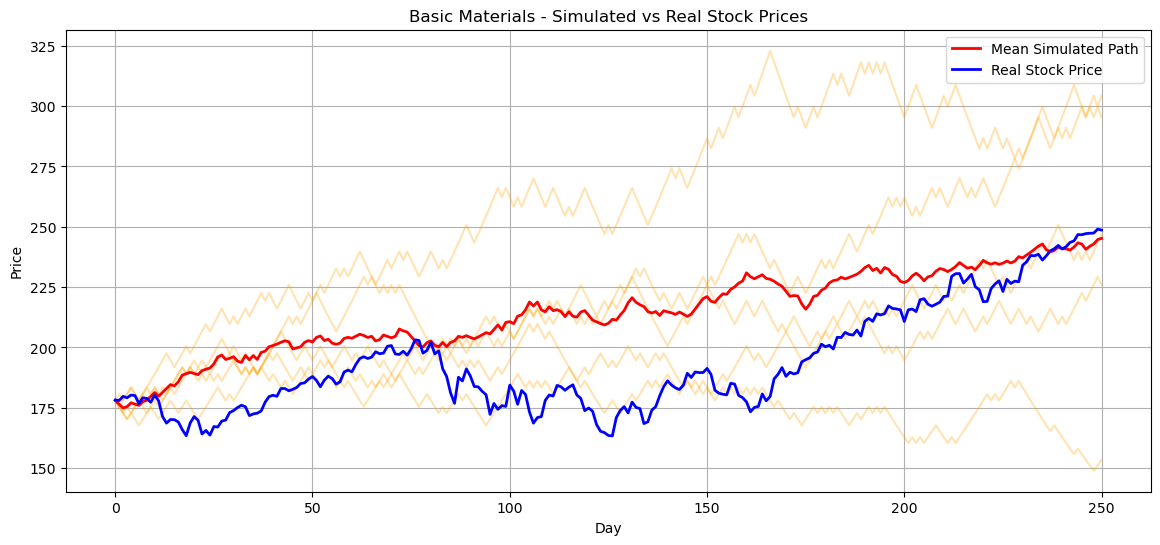

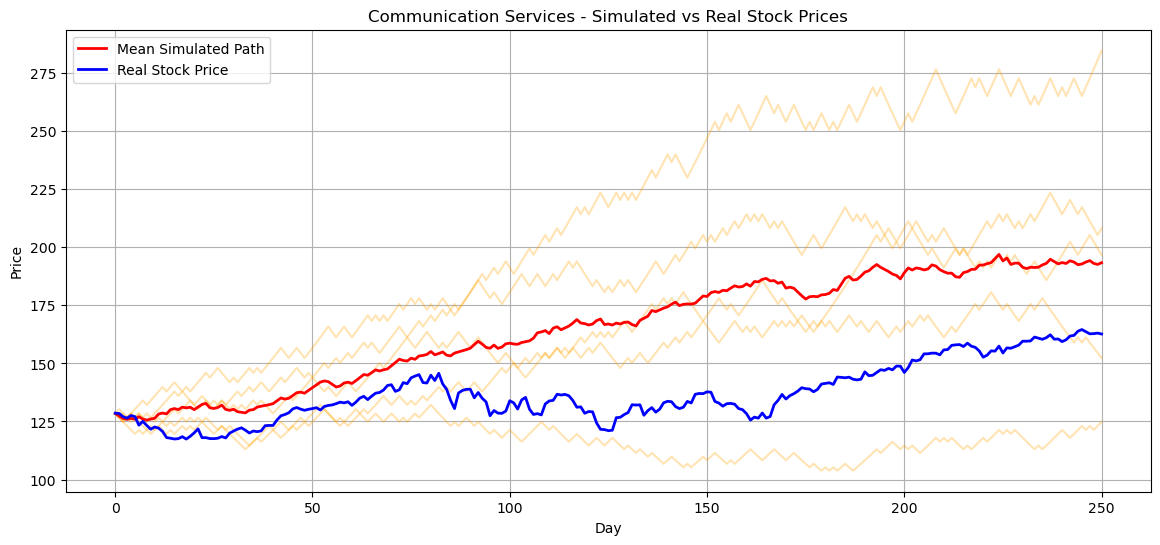

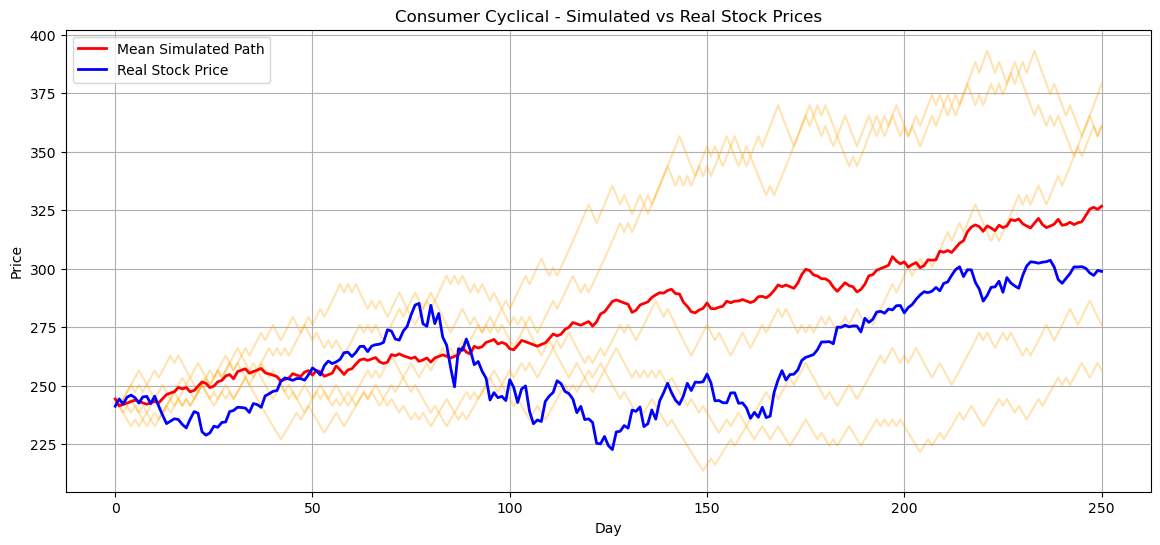

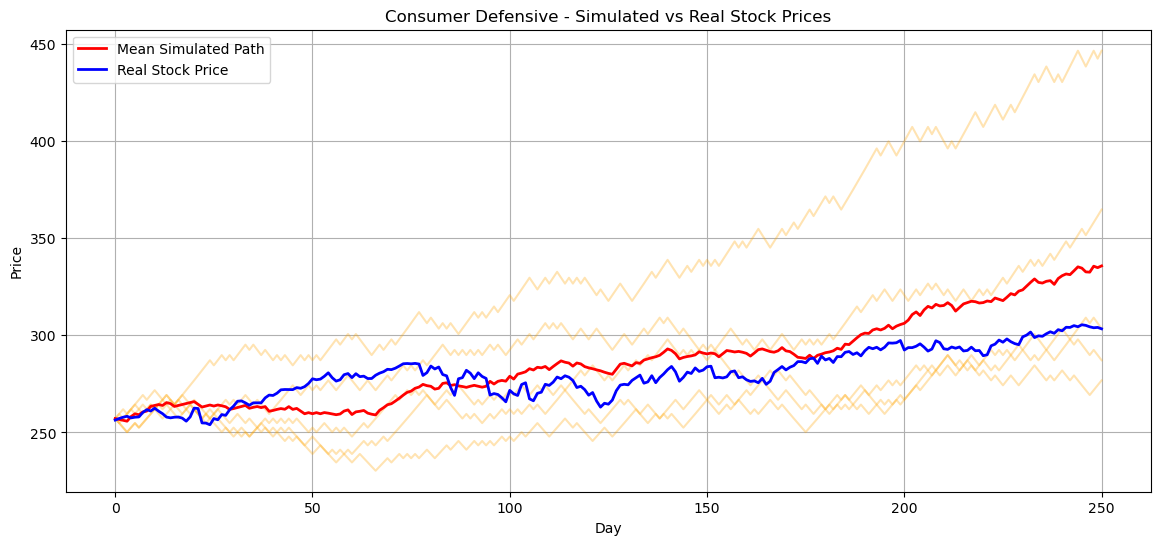

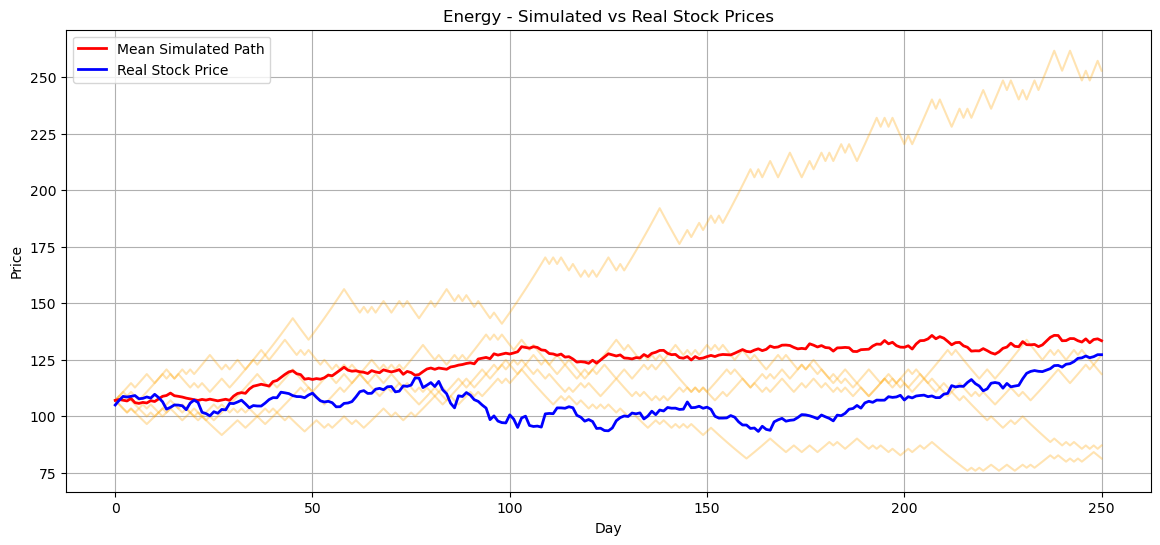

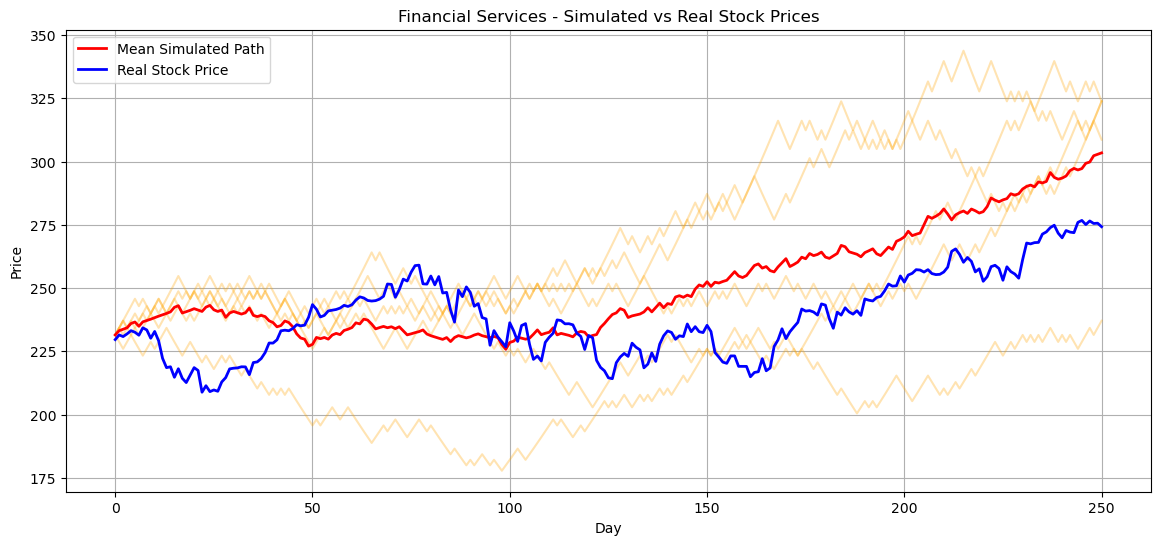

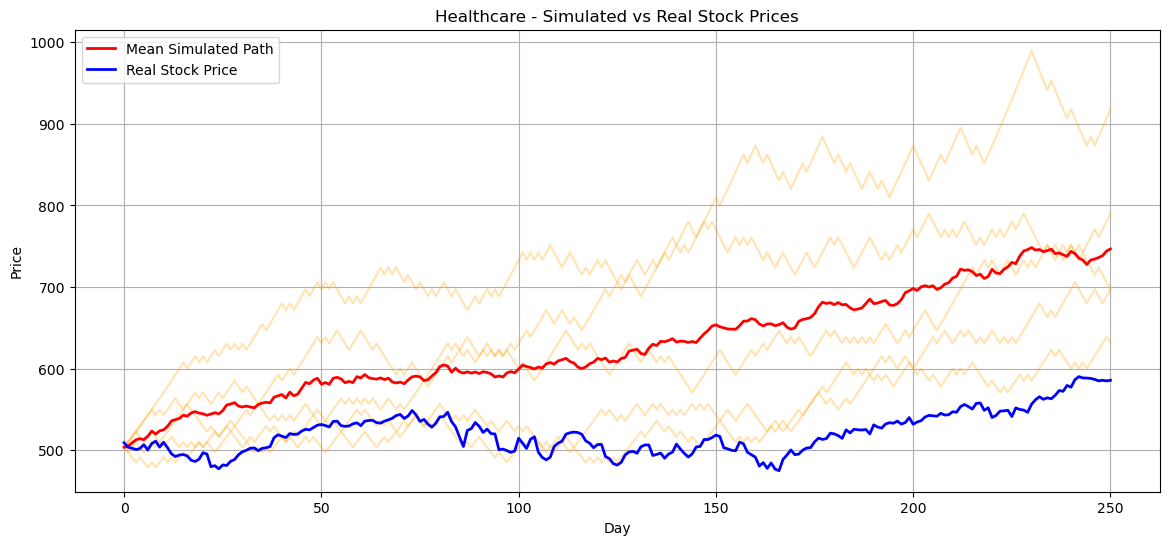

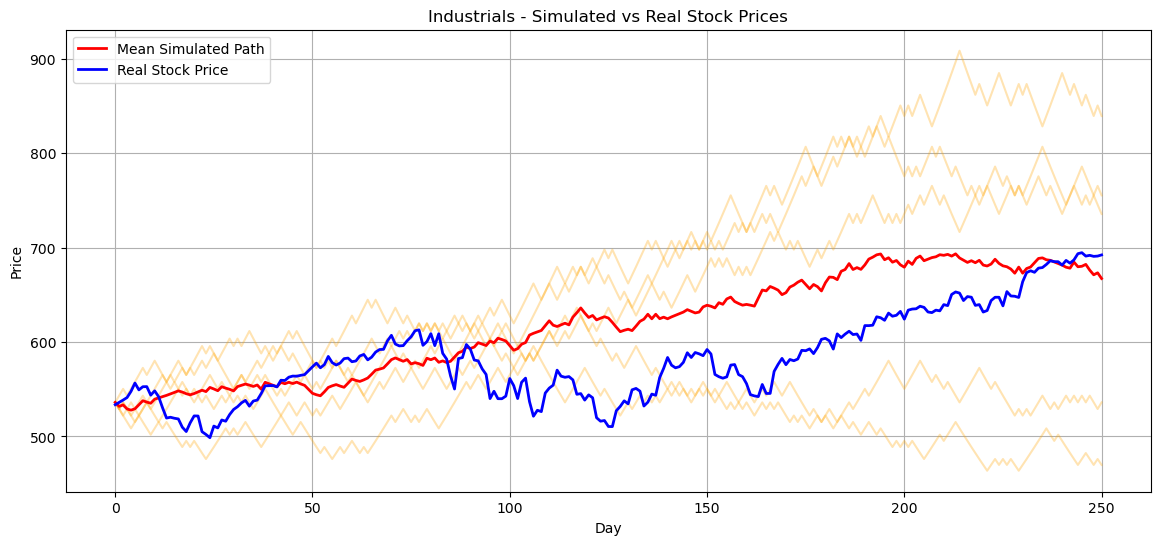

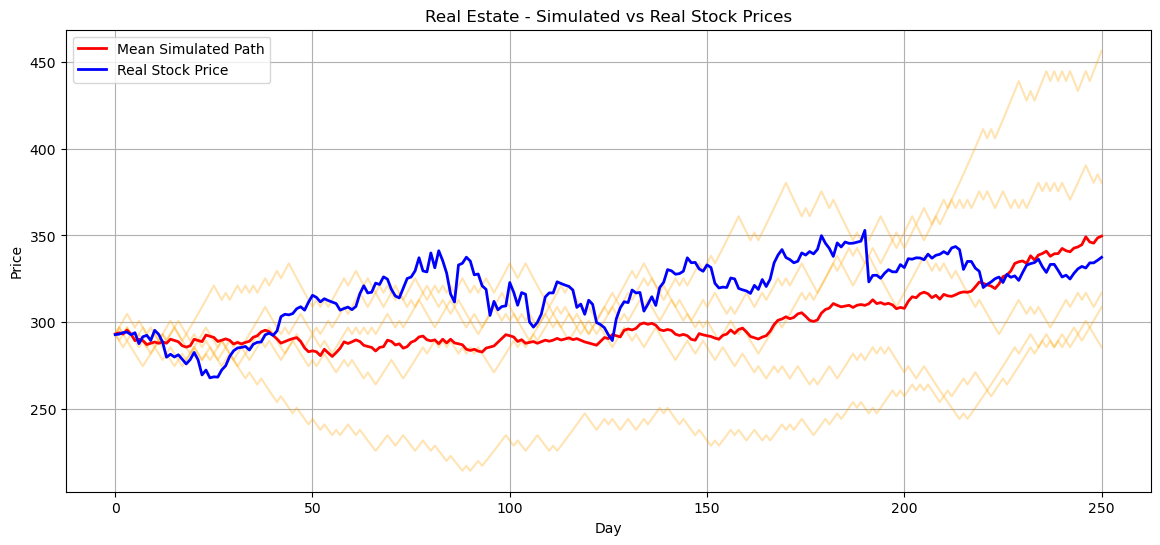

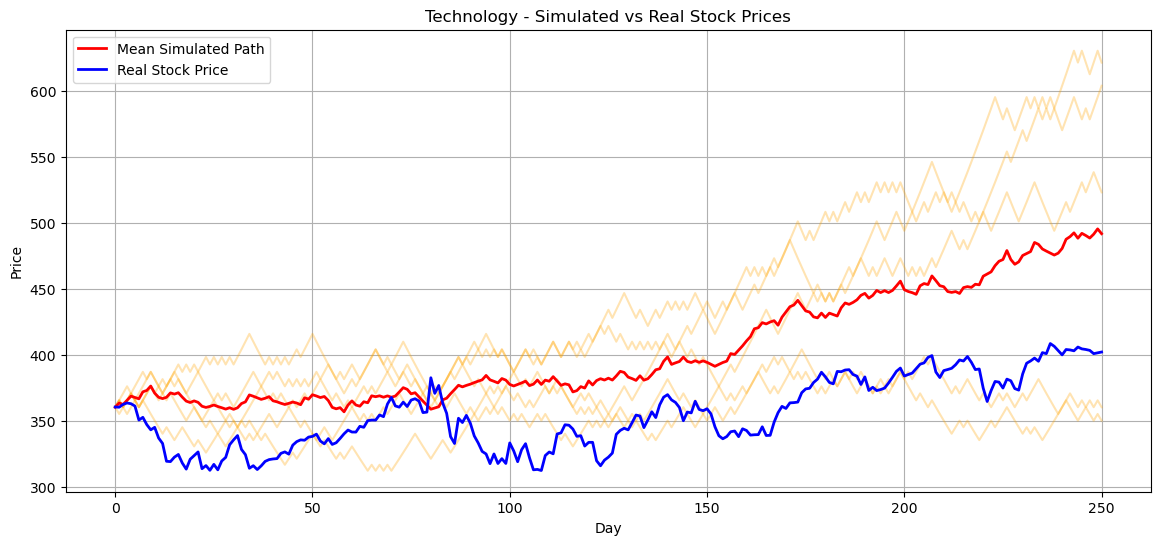

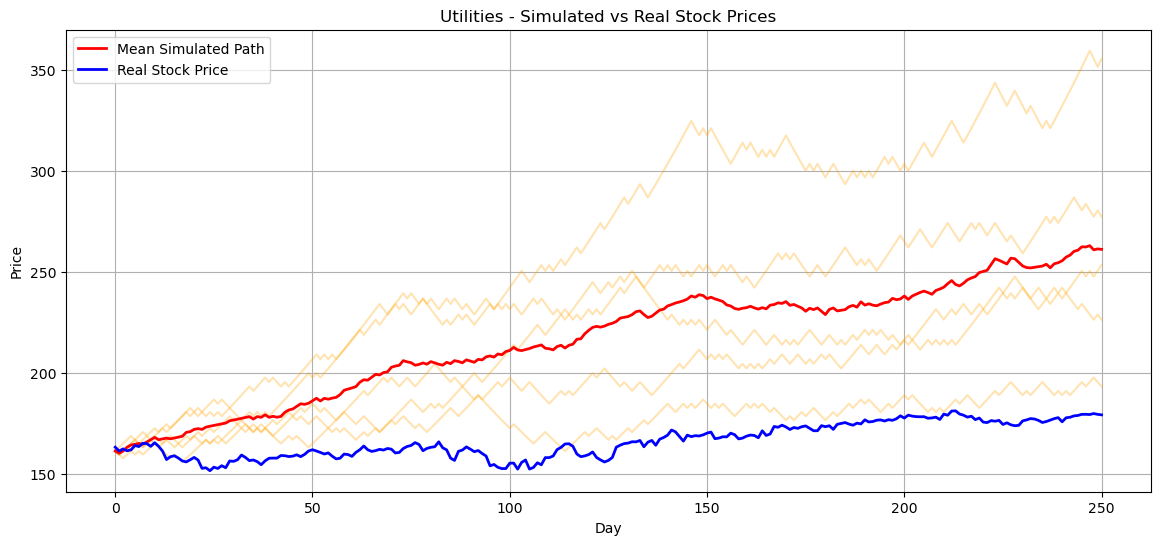

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sectors = stocks_data["Sector"].unique()
sector_mean_paths = {}

# Plot individual simulations + mean path per sector
for sector in sectors:
    # all_paths for this sector
    g = stocks_data[stocks_data["Sector"] == sector].sort_values("Date").copy()
    # Re-run simulations to get all paths array
    current = g["up_ind"].iloc[:-1].to_numpy()
    next_state = g["up_ind"].iloc[1:].to_numpy()
    T_counts = np.zeros((2, 2), dtype=float)
    for c, n in zip(current, next_state):
        T_counts[c, n] += 1
    row_sums = T_counts.sum(axis=1, keepdims=True)
    P = np.divide(T_counts, row_sums, where=row_sums != 0)
    p_up_given_up = P[1, 1]
    p_up_given_down = P[0, 1]

    sigma = g["pctChange"].std()
    u = np.exp(sigma)
    d = np.exp(-sigma)


    s0 = g["Adj Close"].iloc[1]
    last_state = int(g["up_ind"].iloc[1])

    n_sim = 5
    T_sim = 250
    rng = np.random.default_rng()
    all_paths = np.zeros((n_sim, T_sim + 1))

    for sim in range(n_sim):
        s = s0
        state = last_state
        path = [s]
        shocks = rng.uniform(size=T_sim)
        for t in range(T_sim):
            p_up = p_up_given_up if state == 1 else p_up_given_down
            if shocks[t] < p_up:
                s = s * u
                state = 1
            else:
                s = s * d
                state = 0
            path.append(s)
        all_paths[sim, :] = path

    # --- Plot ---
    plt.figure(figsize=(14, 6))
    
    # Individual simulations
    for sim_path in all_paths:
        plt.plot(range(T_sim + 1), sim_path, color='orange', alpha=0.3)

    # Mean path
    mean_path = all_paths.mean(axis=0)
    plt.plot(range(T_sim + 1), mean_path, color='red', linewidth=2, label='Mean Simulated Path')

    # Real stock data (first 250 days or all if fewer)
    real_prices = g['Adj Close'].iloc[:T_sim + 1]
    plt.plot(range(len(real_prices)), real_prices, color='blue', linewidth=2, label='Real Stock Price')

    plt.title(f"{sector} - Simulated vs Real Stock Prices")
    plt.xlabel("Day")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()